Load dependencies and set some default output options 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid")

Let's read in the data:

In [2]:
df = pd.DataFrame.from_csv("./data/diamonds.csv")

#### And start with some basic familiarization:

In [3]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df["cut"].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [5]:
df["color"].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

In [6]:
df["clarity"].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'], dtype=object)

In [7]:
total_size = len(df)
print(total_size)

53940


In [8]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


This all looks pretty good: 

- we have a total of 53940 entries in the dataset
- all columns from the data description are present
- There seem to be no missing values (NaN)
- The attribute-values found in the dataset for "cut", "color" and "clarity" coincide with the data description

From the data description, we know how the depth should be computed from x, y and z. Let's see if depth is computed correctly:

In [10]:
df["depth_computed"] = (2 * df["z"]) / (df["x"] + df["y"])

In [11]:
df[["depth", "depth_computed"]].head()

,depth,depth_computed
1,61.5,0.612863
2,59.8,0.597671
3,56.9,0.568966
4,62.4,0.623962
5,63.3,0.632911


In [12]:
df["depth_computed"] = round( ((2 * df["z"]) / (df["x"] + df["y"])) * 100, 1)

In [13]:
df[["depth", "depth_computed"]].sample(5)

,depth,depth_computed
8047,62.6,62.5
22616,61.0,61.0
14337,63.0,63.0
44086,63.3,63.3
35082,61.6,61.7


In [14]:
len(df[df["depth"] != df["depth_computed"]])
len(df[df["depth"] == df["depth_computed"]])

3789

50151

In [15]:
len(df[df["depth"] != df["depth_computed"]]) / total_size

0.07024471635150167

So, we find different values for depth and depth_computed for 7% of the data, let's investigate:

In [16]:
# Compute difference between depth and depth_computed. Ideally depth_difference should be 0
df["depth_difference"] = df["depth"] - df["depth_computed"]

count    53933.000000
mean         0.005462
std          2.629187
min       -557.500000
25%          0.000000
50%          0.000000
75%          0.000000
max         64.000000
Name: depth_difference, dtype: float64

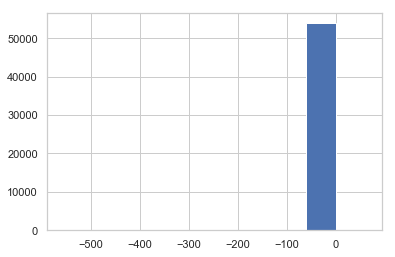

In [17]:
df["depth_difference"].describe()
df["depth_difference"].hist()

In [18]:
df[np.abs(df["depth_difference"]) > 1]

,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference
2208,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.00,0.0,59.1
2275,1.22,Premium,J,SI2,62.6,59.0,3156,6.79,4.24,3.76,68.2,-5.6
2315,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.00,0.0,58.1
2350,0.70,Ideal,G,VS2,62.7,54.0,3172,5.65,5.70,3.65,64.3,-1.6
2942,1.00,Very Good,J,SI2,62.8,63.0,3293,6.26,6.19,3.19,51.2,11.6
3512,0.70,Premium,E,IF,62.9,59.0,3403,5.66,5.59,3.40,60.4,2.5
4125,1.01,Fair,F,SI2,64.6,59.0,3540,6.19,6.25,4.20,67.5,-2.9
4519,1.00,Fair,G,SI1,43.0,59.0,3634,6.32,6.27,3.97,63.1,-20.1
4688,0.81,Premium,E,VS2,61.5,58.0,3674,5.99,5.94,3.97,66.6,-5.1
4792,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.00,0.0,63.0


From the table above, we see actually some entries which have a z-value of 0.00, and indeed we could have already seen this from df.describe() above (x, y and z have a minium value of 0.00!)

In [19]:
df[df["x"] == 0]
df[df["y"] == 0]
df[df["z"] == 0]

,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference
11183,1.07,Ideal,F,SI2,61.6,56.0,4954,0.0,6.62,0.0,0.0,61.6
11964,1.00,Very Good,H,VS2,63.3,53.0,5139,0.0,0.00,0.0,NaN,NaN
15952,1.14,Fair,G,VS1,57.5,67.0,6381,0.0,0.00,0.0,NaN,NaN
24521,1.56,Ideal,G,VS2,62.2,54.0,12800,0.0,0.00,0.0,NaN,NaN
26244,1.20,Premium,D,VVS1,62.1,59.0,15686,0.0,0.00,0.0,NaN,NaN
27430,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.00,0.0,NaN,NaN
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.0,0.00,0.0,NaN,NaN
49558,0.71,Good,F,SI2,64.1,60.0,2130,0.0,0.00,0.0,NaN,NaN


,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference
11964,1.00,Very Good,H,VS2,63.3,53.0,5139,0.0,0.0,0.0,NaN,NaN
15952,1.14,Fair,G,VS1,57.5,67.0,6381,0.0,0.0,0.0,NaN,NaN
24521,1.56,Ideal,G,VS2,62.2,54.0,12800,0.0,0.0,0.0,NaN,NaN
26244,1.20,Premium,D,VVS1,62.1,59.0,15686,0.0,0.0,0.0,NaN,NaN
27430,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.0,0.0,NaN,NaN
49557,0.71,Good,F,SI2,64.1,60.0,2130,0.0,0.0,0.0,NaN,NaN
49558,0.71,Good,F,SI2,64.1,60.0,2130,0.0,0.0,0.0,NaN,NaN


,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference
2208,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0,0.0,59.1
2315,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0,0.0,58.1
4792,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0,0.0,63.0
5472,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0,0.0,59.2
10168,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0,0.0,64.0
11183,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0,0.0,61.6
11964,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0,NaN,NaN
13602,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0,0.0,59.2
15952,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0,NaN,NaN
24395,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0,0.0,59.4


Let's get rid of all the entries where we have 2 or more missing dimension values; all entries where "x" or "y" are missing have at least two missing dimension values. So let's delete those:

In [20]:
df = df[df["x"] != 0]
df = df[df["y"] != 0]

In [21]:
df[df["x"] == 0]
df[df["y"] == 0]
df[df["z"] == 0]

,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference


,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference


,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference
2208,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0,0.0,59.1
2315,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0,0.0,58.1
4792,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0,0.0,63.0
5472,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0,0.0,59.2
10168,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0,0.0,64.0
13602,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0,0.0,59.2
24395,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0,0.0,59.4
26124,2.25,Premium,I,SI1,61.3,58.0,15397,8.52,8.42,0.0,0.0,61.3
27113,2.20,Premium,H,SI1,61.2,59.0,17265,8.42,8.37,0.0,0.0,61.2
27504,2.02,Premium,H,VS2,62.7,53.0,18207,8.02,7.95,0.0,0.0,62.7


The remaining entries we could either delete or impute using x, y and depth values, let's do the latter:


```
df["depth"] = ((2 * df["z"]) / (df["x"] + df["y"])) * 100

-->

df["depth"] / 100 = (2 * df["z"]) / (df["x"] + df["y"])

-->

(df["depth"] / 100) * (df["x"] + df["y"]) = 2 * df["z"]

-->

(df["depth"] / (100 * 2)) * (df["x"] + df["y"]) = df["z"]
```

In [22]:
## only fill the values where z equals zero
df.loc[df["z"] == 0, "z"] = ((df["depth"] / (100 * 2)) * (df["x"] + df["y"])).round(2)

In [23]:
## Check the result
df[df["depth_computed"] == 0]

,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference
2208,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,3.85,0.0,59.1
2315,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,3.85,0.0,58.1
4792,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,4.09,0.0,63.0
5472,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,3.84,0.0,59.2
10168,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,4.54,0.0,64.0
13602,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,4.06,0.0,59.2
24395,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,5.03,0.0,59.4
26124,2.25,Premium,I,SI1,61.3,58.0,15397,8.52,8.42,5.19,0.0,61.3
27113,2.20,Premium,H,SI1,61.2,59.0,17265,8.42,8.37,5.14,0.0,61.2
27504,2.02,Premium,H,VS2,62.7,53.0,18207,8.02,7.95,5.01,0.0,62.7


Now, recompute depth_computed and check remaining strange values:

In [24]:
df["depth_computed"] = round( ((2 * df["z"]) / (df["x"] + df["y"])) * 100, 1)
df["depth_difference"] = df["depth"] - df["depth_computed"]
df["z_imputed"] = ((df["depth"] / (100 * 2)) * (df["x"] + df["y"])).round(2)
df[np.abs(df["depth_difference"]) > 1].sort_values("depth_difference")

,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference,z_imputed
48411,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,31.80,619.3,-557.5,3.17
49906,0.50,Very Good,G,VVS1,63.7,58.0,2180,5.01,5.04,5.06,100.7,-37.0,3.20
34283,0.39,Premium,H,SI2,61.2,58.0,468,4.51,6.02,4.44,84.3,-23.1,3.22
6342,1.00,Fair,G,VS2,44.0,53.0,4032,6.31,6.24,4.12,65.7,-21.7,2.76
4519,1.00,Fair,G,SI1,43.0,59.0,3634,6.32,6.27,3.97,63.1,-20.1,2.71
10378,1.09,Ideal,J,VS2,43.0,54.0,4778,6.53,6.55,4.12,63.0,-20.0,2.81
25850,2.00,Premium,G,SI1,59.0,62.0,14918,6.16,6.15,4.82,78.3,-19.3,3.63
26496,2.06,Premium,H,SI2,60.0,60.0,16098,6.29,6.25,4.96,79.1,-19.1,3.76
26195,2.01,Fair,G,SI2,65.6,56.0,15562,7.89,7.84,6.16,78.3,-12.7,5.16
17594,1.00,Fair,D,VS1,55.9,60.0,7083,6.77,6.71,4.38,65.0,-9.1,3.77


Eyeballing this data, we do see some clear errors, for example the first line (index = 48411) we see a z-value of 31.80 which should probably be 3.18 ("z_imputed" = 3.17..) but let's not waste too much time here and just remove all data with a "depth_difference" of larger than 2 (absolute value)

In [25]:
df = df[np.abs(df["depth_difference"]) < 2]

In [26]:
df[np.abs(df["depth_difference"]) > 1].sort_values("depth_difference")

,carat,cut,color,clarity,depth,table,price,x,y,z,depth_computed,depth_difference,z_imputed
50488,0.70,Premium,G,SI2,60.0,60.0,2268,5.69,5.65,3.51,61.9,-1.9,3.40
51156,0.62,Ideal,F,VS1,61.9,55.0,2344,5.46,5.19,3.39,63.7,-1.8,3.30
12918,1.28,Premium,H,SI2,60.2,60.0,5376,6.97,6.93,4.31,62.0,-1.8,4.18
41692,0.54,Premium,F,SI2,60.0,60.0,1240,5.27,5.22,3.24,61.8,-1.8,3.15
16858,1.43,Fair,I,VS1,50.8,60.0,6727,7.73,7.25,3.93,52.5,-1.7,3.80
2350,0.70,Ideal,G,VS2,62.7,54.0,3172,5.65,5.70,3.65,64.3,-1.6,3.56
25079,1.36,Premium,E,VVS2,59.8,59.0,13598,7.12,7.20,4.38,61.2,-1.4,4.28
42235,0.40,Ideal,E,VS1,61.1,57.0,1291,4.75,4.78,2.97,62.3,-1.2,2.91
44614,0.53,Premium,E,SI1,60.0,60.0,1607,5.27,5.24,3.21,61.1,-1.1,3.15
52261,0.78,Premium,H,SI1,60.0,60.0,2489,5.93,5.92,3.62,61.1,-1.1,3.56


Comparing z and z_imputed values: they seem pretty close to eachother so let's leave it at this.

In [27]:
len(df)

53878

In [28]:
len(df) / total_size

0.9988505747126437

we still have 99.9% of the data

In [29]:
df = df.drop(["depth_computed", "depth_difference", "z_imputed"], axis = 1)

Now, let's look at the correlations between the numeric variables

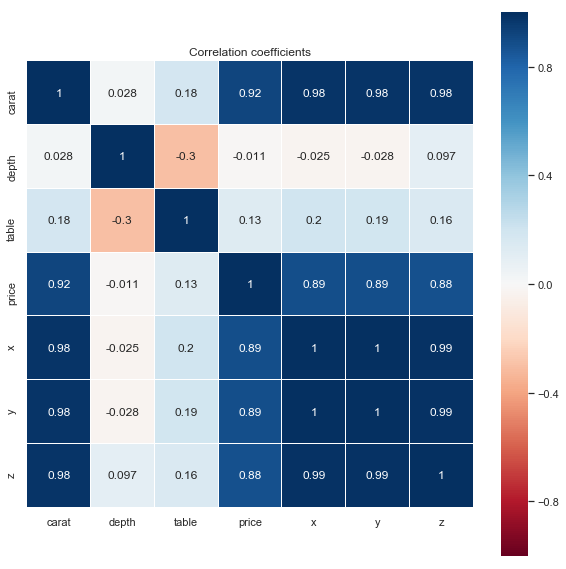

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df.corr(), 
                 square=True, 
                 annot=True, 
                 cmap="RdBu", 
                 vmin=-1, vmax=1, 
                 linewidth=0.1);
ax.set_title('Correlation coefficients');

We see very high positive correlations:

- between x, y and z (dimension data)
- between dimension data and carat
- between carat and price
- and thus also between dimension data and price

Let's have a look at the dimension data; x, y, z and carat:

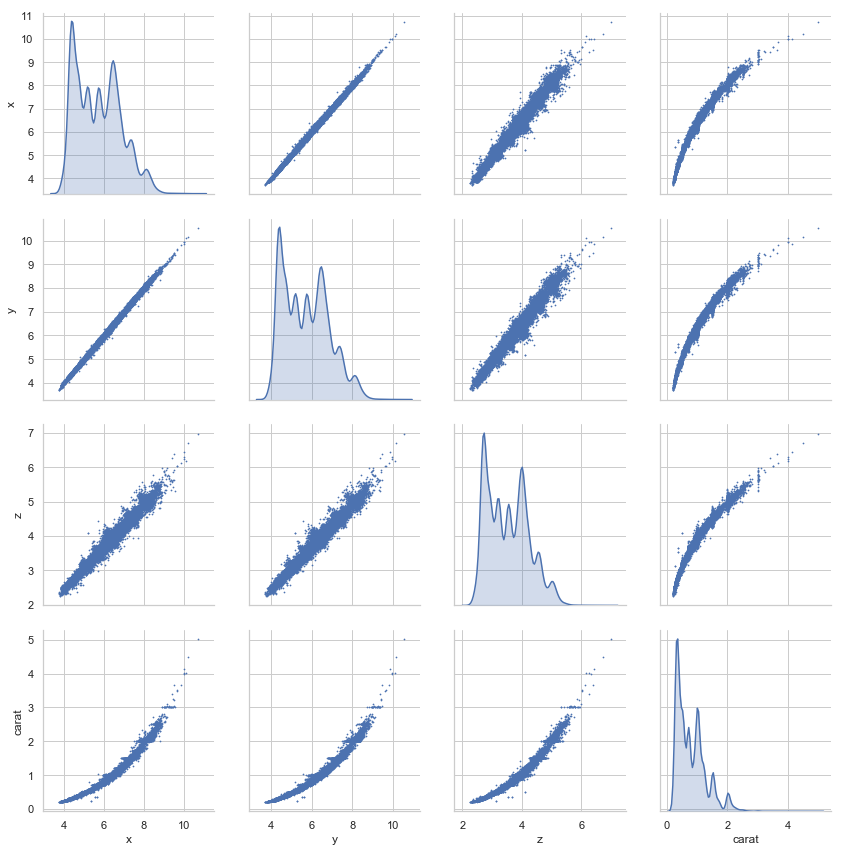

In [31]:
ax = sns.pairplot(df,
                  vars=["x", "y", "z", "carat"],
                  kind="scatter",
                  diag_kind="kde",
                  height=3,
                  plot_kws={"linewidth":0, "s":3});

Because of the observed very high correlation between the dimensions, and the fact that the carat (weight) is a proxy for volume we see something like a (third degree) polynomial relation between individual dimensions and carat. Looking at the lower-right figure (carat KDE), we also see that most data describes smaller diamonds, with a couple of spikes showing that some certain, specific carat values are more common then others. Finally, we don't see a sign of outliers

Next, we want to compare the size/weight of the diamond with the price. For this we will plot carat vs price

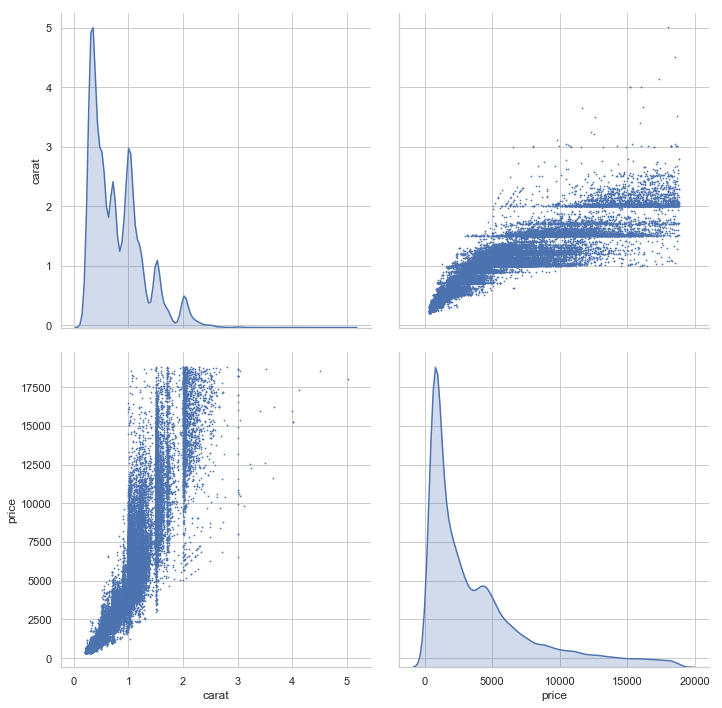

In [32]:
ax = sns.pairplot(df,
                  vars=["carat", "price"],
                  kind="scatter",
                  diag_kind="kde",
                  height=5,
                  plot_kws={"linewidth":0, "s":3});

Here we see that the price KDE is much smoother than the carat KDE, this is also supported by the observation of the "fanning out" of the price at higher carat values: there is more variance in price at higher carats then at small carats. Also we see the spikes in the carat KDE reflected in the carat/price scatter by the vertical dense lines (lower-left plot), let's take a closer look:

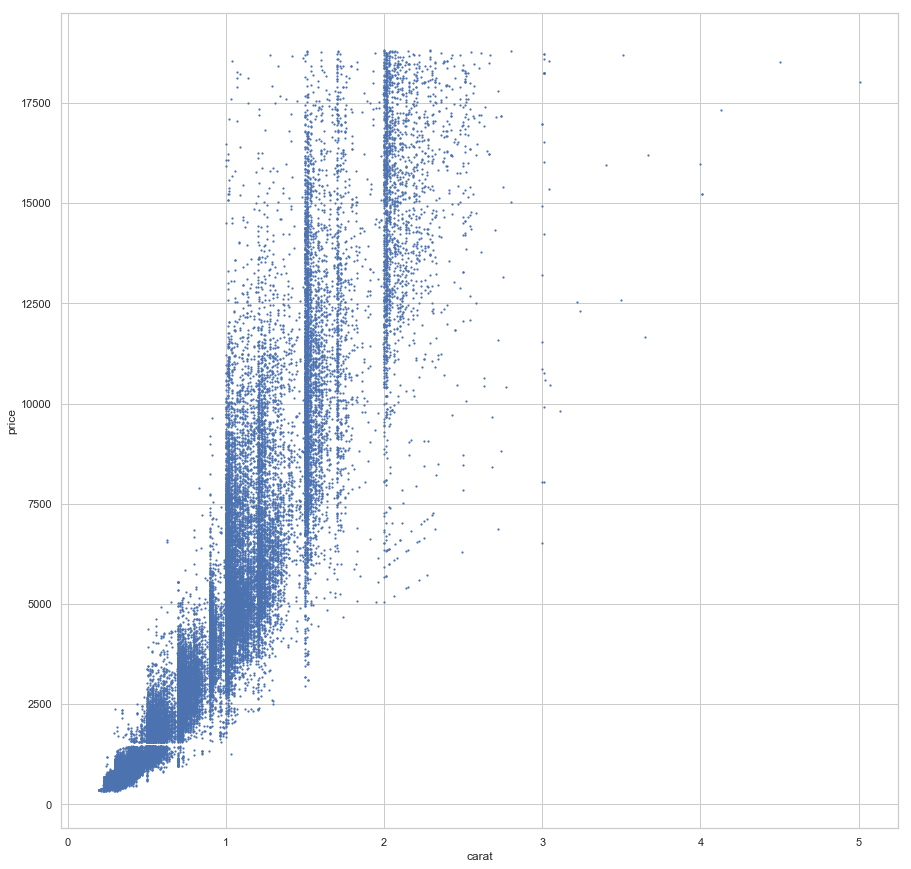

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x="carat", 
                y="price", 
                data=df, 
                linewidth=0, 
                s = 5)

In [34]:
groups = list(range(20,0,-1))
def caratGroups(carat):
    if carat < 0.5:
        return 0
    elif 0.5 <= carat < 0.7:
        return 1
    elif 0.7 <= carat < 0.8:
        return 2
    elif 0.8 <= carat < 0.9:
        return 3
    elif 0.9 <= carat < 1:
        return 4
    elif 1 <= carat < 1.2:
        return 5
    elif 1.2 <= carat < 1.5:
        return 6
    elif 1.5 <= carat < 1.7:
        return 7
    elif 1.7 <= carat < 2:
        return 8
    elif 2 <= carat:
        return 9

df['carat_group'] = df["carat"].apply(lambda x: caratGroups(x))

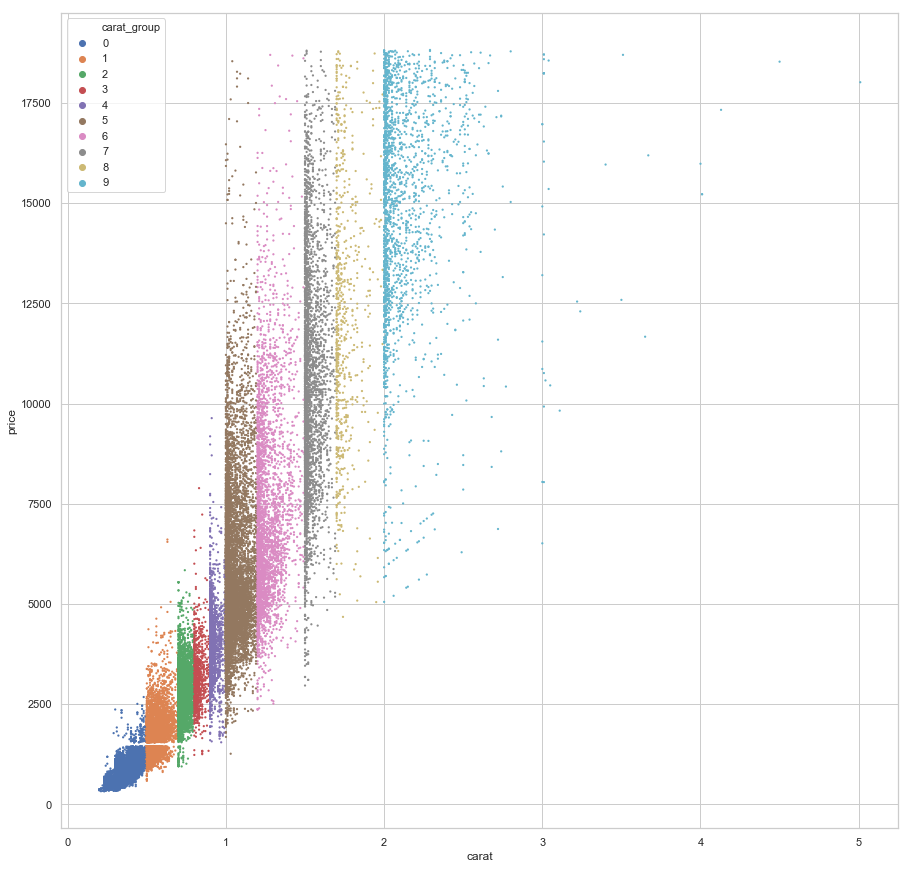

In [35]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x="carat", 
                y="price", 
                data=df, 
                linewidth=0, 
                s = 5, 
                hue="carat_group", 
                palette=sns.color_palette("deep", n_colors=df["carat_group"].nunique()))

Besides the observed groups, we also notice that the relation between price and carat seems to be non-linear, perhaps quadratic or exponential. Intuitively this makes sense because larger (heavier) stones are probably much more rare then smaller ones.

Let's investigate the influence of the categorical variables

In [36]:
df.groupby("cut").count().sort_values("carat")

,carat,color,clarity,depth,table,price,x,y,z,carat_group
cut,,,,,,,,,,
Fair,1597,1597,1597,1597,1597,1597,1597,1597,1597,1597
Good,4903,4903,4903,4903,4903,4903,4903,4903,4903,4903
Very Good,12076,12076,12076,12076,12076,12076,12076,12076,12076,12076
Premium,13765,13765,13765,13765,13765,13765,13765,13765,13765,13765
Ideal,21537,21537,21537,21537,21537,21537,21537,21537,21537,21537


Pretty unbalanced groups, smallest group ("Fair") has less than 10% of the largest group ("Ideal")

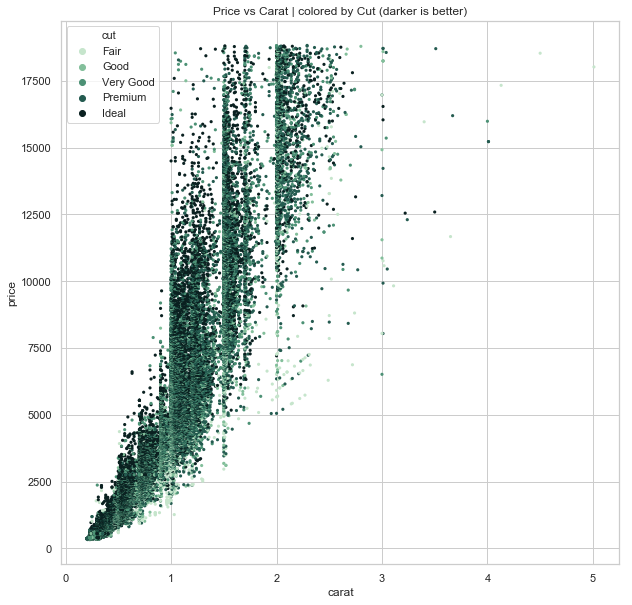

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="carat", 
                y="price", 
                data=df, 
                linewidth=0, 
                s = 10, 
                hue="cut",
                hue_order=["Fair", "Good", "Very Good", "Premium", "Ideal"],
                palette=sns.color_palette(palette="ch:2.5,-.2,dark=.1", n_colors=df["cut"].nunique()))
ax.set_title("Price vs Carat | colored by Cut (darker is better)")

In [38]:
df.groupby("clarity").count().sort_values("carat")

,carat,cut,color,depth,table,price,x,y,z,carat_group
clarity,,,,,,,,,,
I1,740,740,740,740,740,740,740,740,740,740
IF,1789,1789,1789,1789,1789,1789,1789,1789,1789,1789
VVS1,3651,3651,3651,3651,3651,3651,3651,3651,3651,3651
VVS2,5064,5064,5064,5064,5064,5064,5064,5064,5064,5064
VS1,8162,8162,8162,8162,8162,8162,8162,8162,8162,8162
SI2,9177,9177,9177,9177,9177,9177,9177,9177,9177,9177
VS2,12247,12247,12247,12247,12247,12247,12247,12247,12247,12247
SI1,13048,13048,13048,13048,13048,13048,13048,13048,13048,13048


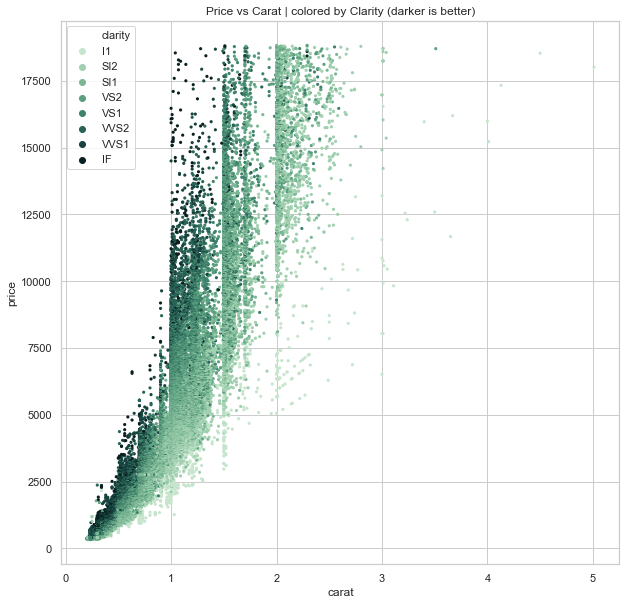

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="carat", 
                y="price", 
                data=df, 
                linewidth=0, 
                s = 10, 
                hue="clarity",
                hue_order=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
                palette=sns.color_palette(palette="ch:2.5,-.2,dark=.1", n_colors=df["clarity"].nunique()))
ax.set_title("Price vs Carat | colored by Clarity (darker is better)")

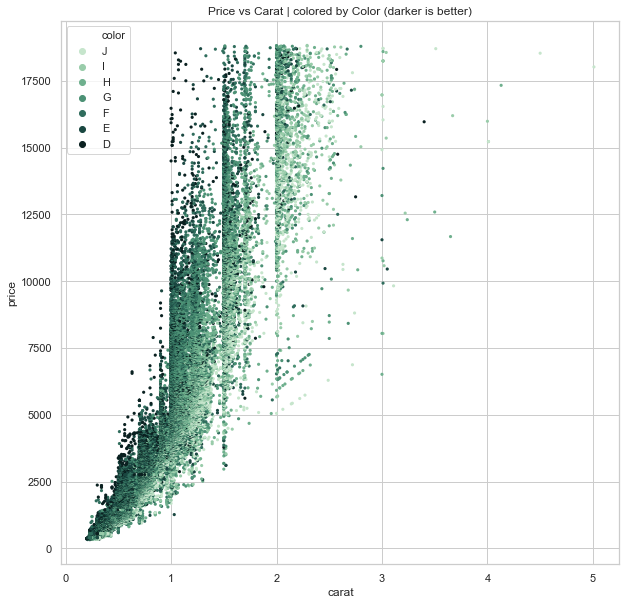

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="carat", 
                y="price", 
                data=df, 
                linewidth=0, 
                s = 10, 
                hue="color",
                hue_order=["J", "I", "H", "G", "F", "E", "D"],
                palette=sns.color_palette(palette="ch:2.5,-.2,dark=.1", n_colors=df["color"].nunique()))
ax.set_title("Price vs Carat | colored by Color (darker is better)")

Especially for "Cut" and "Clarity" we see a clear effect; darker values (better cuts and clarities) tend to be higher priced diamonds. Let's create a Facetgrid from this:

- left-to-right -> clarity
- top-to-bottom -> color
- x-axis -> carat
- y-axis -> price

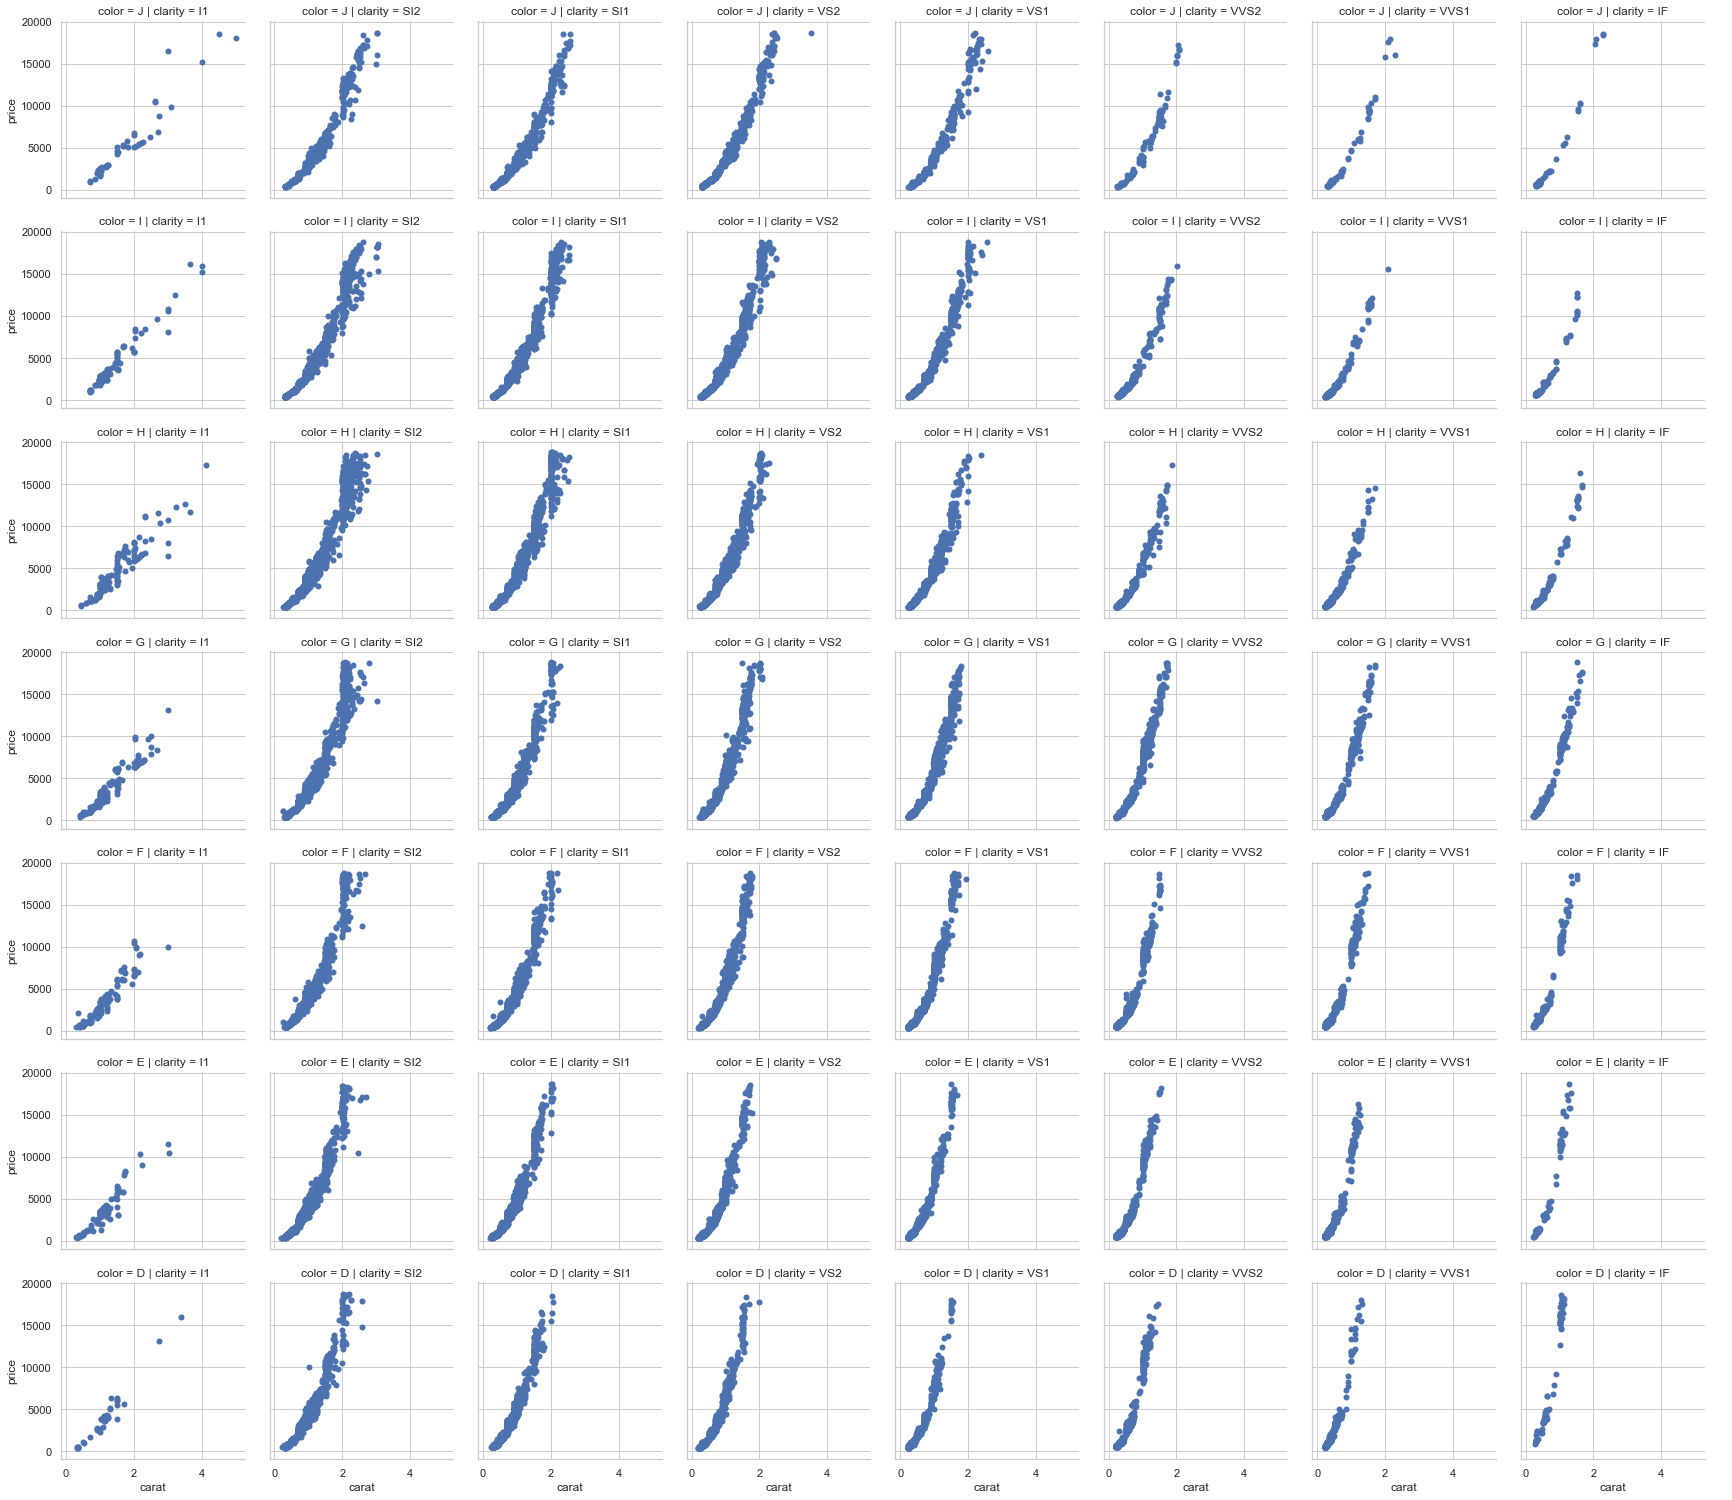

In [41]:
g = sns.FacetGrid(df, 
                  col="clarity",
                  col_order=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
                  row="color",
                  row_order=["J", "I", "H", "G", "F", "E", "D"],
                  #hue="cut",
                  #hue_order=["Fair", "Good", "Very Good", "Premium", "Ideal"],
                  #palette=sns.color_palette(palette="ch:2.5,-.2,dark=.3", n_colors=df["cut"].nunique())
                 )
g = (g.map(plt.scatter, "carat", "price", linewidth=0).add_legend())

Here we see two things:

- from left-to-right: the scatterplots become more steep. This shows that with increasing clarity, the prices of diamonds rise faster with increasing carats.
- from top-to-botom: the scatterplots also become more steep. This shows that with increasing (quality of) color, the prices of diamonds rise faster with increasing carats.

Let's look again at cut:

- left-to-right -> cut
- top-to-bottom -> color
- x-axis -> carat
- y-axis -> price

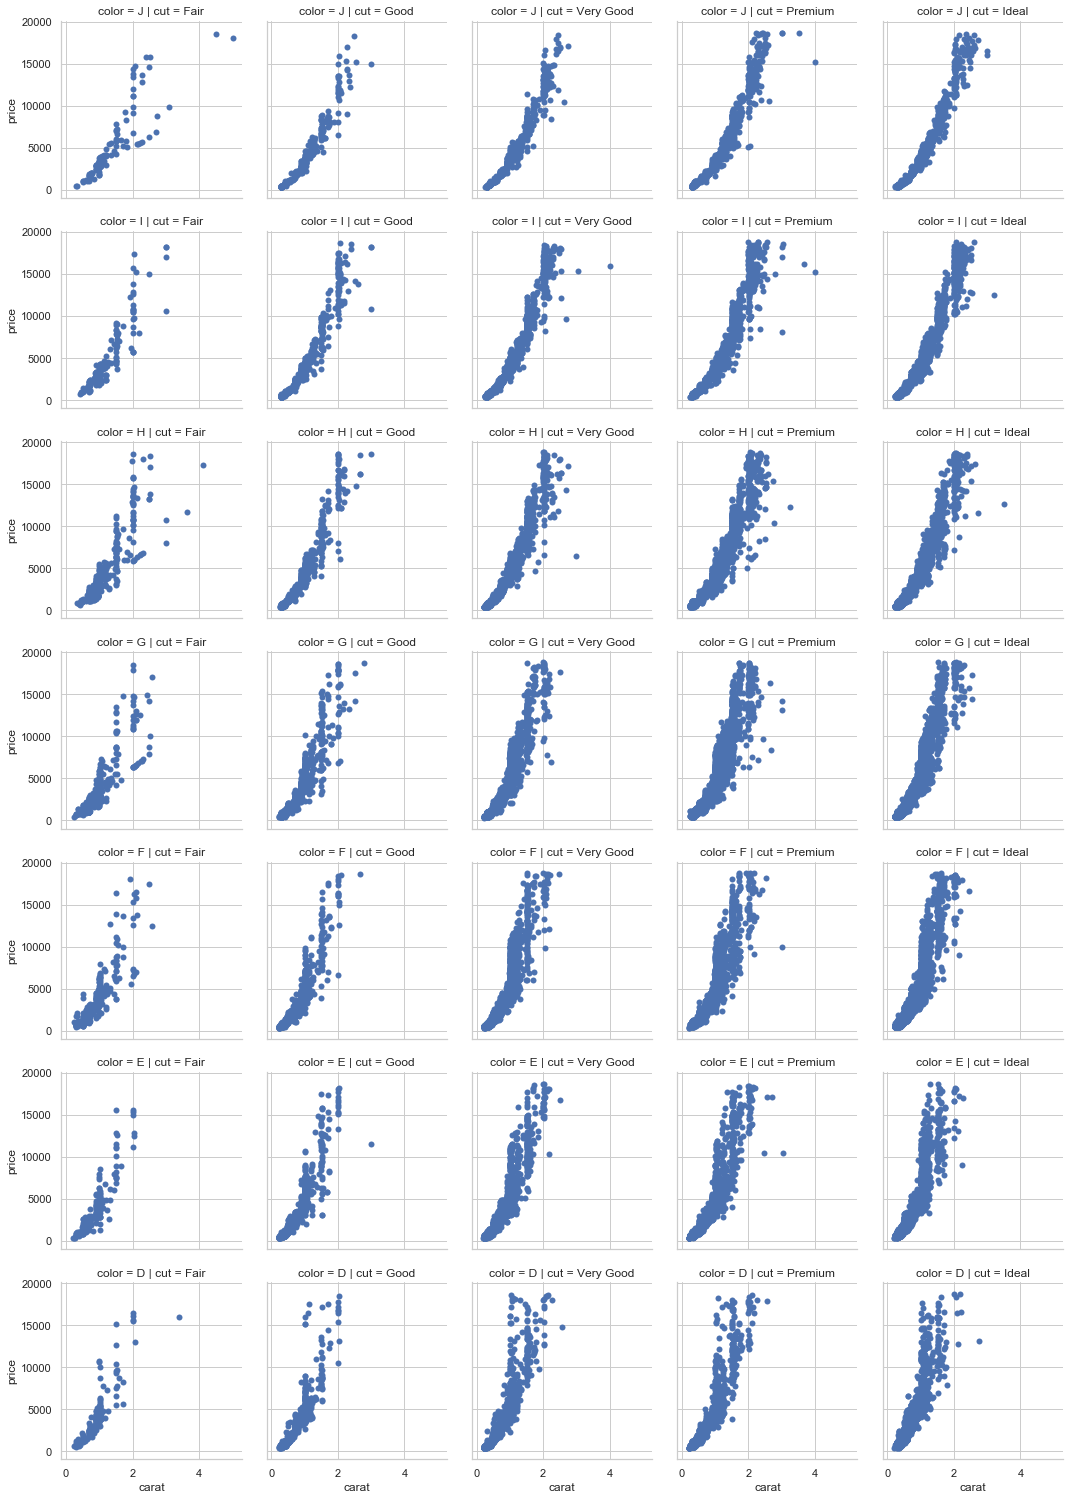

In [42]:
g = sns.FacetGrid(df, 
                  col="cut",
                  col_order=["Fair", "Good", "Very Good", "Premium", "Ideal"],
                  row="color",
                  row_order=["J", "I", "H", "G", "F", "E", "D"])
g = (g.map(plt.scatter, "carat", "price", linewidth=0).add_legend())

Overall, there is still much more variance visible when we include "Cut". For some reason the "Cut" seems to be less predictive of price then "Color" and "Clarity". 

Now let's do a benchmark regression as an initial model

In [43]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_group
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,0
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,0
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,0
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,0


In [44]:
df = df.drop("carat_group", axis = 1)

Since we don't want to assume linear relations between the different categorical values, let's use dummy variables for the categorical variables

In [45]:
df = pd.get_dummies(df, columns=['cut','color','clarity'])

In [46]:
df.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
1,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [47]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [48]:
lr = LinearRegression()
lr.fit(X_train , y_train)
accuracies = cross_val_score(estimator = lr, 
                             X = X_train, 
                             y = y_train, 
                             cv = 5)
y_pred = lr.predict(X_test)
print("####### Linear Regression #######")
print("Score : {}".format(lr.score(X_test, y_test)))
print(accuracies)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

####### Linear Regression #######
Score : 0.9184824214643644
[ 0.92373672  0.92162168  0.92072898  0.91787275  0.92602876]


So we have a benchmark model with an R^2 score of 91.8% which seems pretty decent for a first model

Let's have a short look at the residuals:

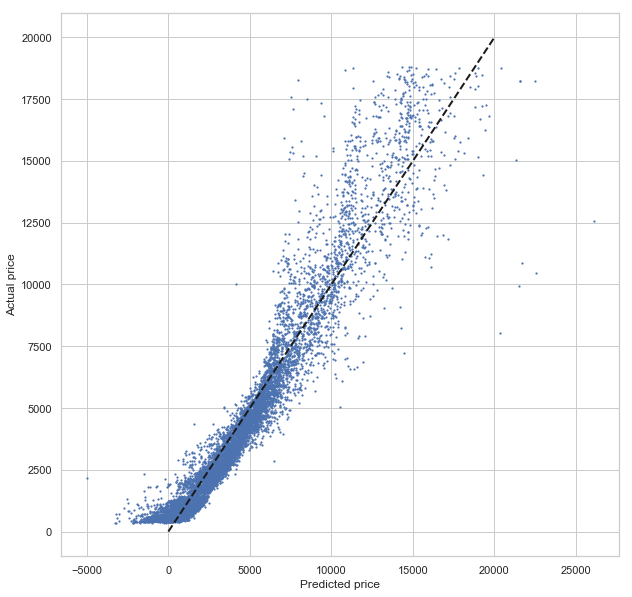

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x=y_pred,
                y=y_test.values,  
                linewidth=0, 
                s=5,
                ax=ax)

ax.plot([0, 20000], [0, 20000], 'k--', lw=2)
ax.set_xlabel('Predicted price')
ax.set_ylabel('Actual price')

So it seems we have heteroskedascity in our model. The variance of the error term is much larger for higher values of the price, then for lower values meaning we should interpret standard errors and all related statistics with caution. 